In [ ]:
# main: CellPhoneDB, celltalker, CellChat

In [1]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

In [2]:
dir.create("backup/b2/") #CellTalk/

outputRoot=paste0( getwd(), "/backup/b2/") 
outputRoot

Warning message in dir.create("backup/b2/"):
“'backup/b2' already exists”


[1] "/data/wangjl/scScripts/backup/b2/"

In [4]:
##
library(Seurat)
library(monocle)

library(tidyverse)
library(patchwork)

# 细胞通信简介

细胞通讯研究领域涵盖的内容很广，包括通讯方式、功能、信号分子以及各种途径的机制。
- 细胞之间通讯的介质有很多，例如钙离子、脂质、多肽、蛋白、外泌体以及电信号等。
- 利用单细胞转录组数据分析的细胞通讯，仅限于蛋白质配体-受体复合物介导的细胞间通讯。
     * **其分析的基础是基因表达数据和配体-受体数据库信息**，例如转录组数据表明A、B细胞分别表达了基因α和β，通过数据库查询α和β是配体-受体关系，则认为A-B通过α-β途径进行了通讯。

## 细胞通讯分析工具

目前利用单细胞转录组数据分析细胞通讯的工具有CellPhoneDB，celltalker和iTALK。
 - CellPhoneDB相关的文章2018年发表在Nature上，升级后又发了一篇Nature Protocols，在三者之中最权威。
 - iTALK的可视化效果最好，相关文献2019年发表在bioRxiv。celltalker由本专题演示数据来源文章的作者开发，相关文献2020年发表于Immunity。
 - iTALK和celltalker都只有R语言版本，CellPhoneDB可以使用网页版和python版。

## 可视化结果对比 

https://mp.weixin.qq.com/s?__biz=MzI1Njk4ODE0MQ==&mid=2247488392&idx=1&sn=e0aa3d50eb0b1f3251f1ae7cf62c9616

# CellPhoneDB

## CellPhoneDB网页版(停止服务)

CellPhoneDB有网页版和python单机版，建议有linux基础的朋友使用python版，官方教程：https://github.com/Teichlab/cellphonedb. 由于本教程只针对非专业生信人员，所以只介绍网页版的使用。

### CellPhoneDB的优势 

CellPhoneDB的独特之处不是它的算法，而是他们开发的细胞通讯配体-受体数据库。
 - 他们的数据库不仅包含公共资源注释的受体和配体，还有人工挑选的参与细胞通讯的特定蛋白质家族。
 - 他们的数据库还考虑了配体和受体的亚基结构，这是大多数据库和研究没有涉及的，这点对于准确研究多亚基复合物介导的细胞通讯很关键。

CellPhoneDB数据库概况如下图所示：

1. Secreted and membrane proteins: UniProt; Protein families; Literature mining; n=978
2. Protein complexes: Literature mining; PDB; n=112
3. Protein-protein interactions: IMEx & InnateDB; IUPHAR; Literature mining n=878;

## CellPhoneDB 本地版 

登录官网：https://www.cellphonedb.org/explore-sc-rna-seq

网页打开后如下图所示，注意红色标记区域，这些是需要按情况更改的。统计迭代次数最好改成1000.

### 分析数据准备

细胞通讯肯定只能是样本内的，因此我们需要按样本提取数据子集。

In [7]:
#提取HNSCC肿瘤样本HNC01TIL
if(0){
    sp1 <- scRNA[,str_detect(colnames(scRNA),'HNC01TIL')] #提取 细胞barcode 中包含该关键词的cid，这部分subObj
    
    sp1_counts <- as.matrix(sp1@assays$RNA@data)
    sp1_counts <- data.frame(Gene=rownames(sp1_counts), sp1_counts) #最前面添加一列，Gene
    
    sp1_meta <- data.frame(Cell=rownames(sp1@meta.data), cell_type=sp1@meta.data$celltype_Monaco)
    
    # save
    write.table(sp1_counts, "CellTalk/sp1_counts.txt", row.names=F, sep='\t')
    write.table(sp1_meta, "CellTalk/sp1_meta.txt", row.names=F, sep='\t')
}

正常情况下将sp1_counts.txt和sp1_meta.txt文件提交到服务器就可以分析了。

不巧的是我遇到CellPhoneDB服务器忙碌而暂停服务了，
- Note: Analysis of datasets through our webserver is not available due to the size of scRNAseq datasets. Please, try our python package.

因此我用python版本跑，是一个类命令行工具。

#### 使用pbmc数据集测试一下

In [5]:
scRNA <- readRDS("backup/a1/pbmc10k_final.rds")
scRNA

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [6]:
levels(scRNA@active.ident)

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

In [7]:
levels(scRNA@meta.data$seurat_clusters)

[1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14"
[16] "15" "16" "17" "18" "19"

In [6]:
#取子集，1k细胞，4线程需要1个小时。
set.seed(20210216)
scRNA_Sub=subset(scRNA, downsample=100);scRNA_Sub


# data 矩阵
sub_cts <- as.matrix(scRNA_Sub@assays$RNA@data)
sub_cts=data.frame(Gene=rownames(sub_cts), sub_cts)
dim(sub_cts); sub_cts[1:3,1:3]

write.table(sub_cts, paste0(outputRoot,"0_counts.txt"), row.names=F, sep='\t')

An object of class Seurat 
22860 features across 996 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

[1] 22860   997

Gene       AAACGAACAACTCGAT AAACGAACAGACACCC
AL627309.1 AL627309.1 0                0               
AL627309.3 AL627309.3 0                0               
AL627309.5 AL627309.5 0                0

In [7]:
# 分类df
sp1_meta <- data.frame( 
    Cell=rownames(scRNA_Sub@meta.data), 
    cell_type=scRNA_Sub@meta.data$seurat_clusters
)
dim(sp1_meta); head(sp1_meta)

write.table(sp1_meta, paste0(outputRoot, "0_meta.txt"), row.names=F, sep='\t')

[1] 996   2

Cell             cell_type
1 AAACGAACAACTCGAT 2        
2 AAACGAACAGACACCC 3        
3 AAAGAACCAGGTCTCG 10       
4 AAAGGTACAACTTCTT 17       
5 AAAGGTACAGAAGCTG 14       
6 AAAGTCCGTAACTGCT 0

### 安装python包

见另外的b2_sup_CellPhoneDB3.py

- 其实是一个 类命令行 工具。py实现的。

# celltalker

## celltalker分析原理

celltalker的分析同样依赖配体-受体配对信息，它采纳的数据来自Ramilowski et al (Nature Communications, 2015)的研究成果，并且允许用户自己添加配对信息。celltalker分析细胞通讯有它自己的特点：

- celltalker可能更倾向于分析样本之间具有差异的细胞通讯关系，我没有找到分析单个样本细胞通讯的教程，其构建celltalker对象的函数也要求输入分组信息。

- 为了保证分析的可靠性，它要求一个分组要有几个重复样本。

- celltalker认定细胞进行通讯的前提是配体和受体的表达值在通讯的细胞之间具有一致性。

https://mp.weixin.qq.com/s?__biz=MzI1Njk4ODE0MQ==&mid=2247488392&idx=1&sn=e0aa3d50eb0b1f3251f1ae7cf62c9616

## 使用 //todo

In [8]:
#library(devtools)
#install_github("arc85/celltalker")
library(celltalker)

Loading required package: circlize

circlize version 0.4.12
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




# CellChat

最近已有几种从scRNA-seq数据推断细胞-细胞通信的方法被开发出来，例如SingleCellSignalR、iTalk和NicheNet。但是这些方法通常仅使用一个配体/一个受体基因对，忽略了许多受体起多亚基复合物的作用。

在这里，作者开发了CellChat，这是一个开源R包（https://github.com/sqjin/CellChat）

利用scRNA-seq数据来推断、可视化和分析细胞间通讯。通过分析作者自己的以及公开发表的来自胚胎发育和成年伤口愈合阶段的小鼠皮肤scRNA-seq数据集，展示了CellChat的整体功能。

官网： http://www.cellchat.org/

## 简介：配受体分析

文章: Inference and analysis of cell-cell communication using CellChat
- Suoqin Jin, Christian F. Guerrero-Juarez, Lihua Zhang, Ivan Chang, Peggy Myung, Maksim V. Plikus, Qing Nie
- bioRxiv 2020.07.21.214387; doi: https://doi.org/10.1101/2020.07.21.214387

除了从任何给定的scRNA-seq数据推断细胞间通信外，CellChat还提供了进一步的数据探索、分析和可视化功能。

- 它能够分析细胞与细胞间的通讯，以获得细胞发展轨迹上的连续状态。

- 该方法结合社会网络分析、模式识别和多种学习方法，可以定量地描述和比较推断出的细胞间通信网络。

- 它提供了一个易于使用的工具来提取和可视化推断网络信息。例如，它可以随时预测所有细胞群的主要信号输入和输出，以及这些细胞群和信号如何协调在一起实现功能。

- 它提供了几个可视化输出，以方便用户引导的直观数据解释。

A. 作者手动建立了一个**信号传导因子相互作用数据库，称为CellChatDB**，该数据库涵盖了已知的配体-受体复合物，包括具有多聚体配体和受体的复合物，以及几种类型的辅助因子：可溶性激动剂，拮抗剂，共刺激性和协同性-抑制性膜结合受体。

B. CellChat会为每个细胞组识别差异性过度表达的配体和受体去预测重要的细胞交流。为了建立细胞间通讯，CellChat可以在基于**标签**和**无标签**的模式下运行。
- 在基于标签的模式下，CellChat要求用户分配细胞标签作为输入。
- 在无标签模式下，CellChat要求用户输入数据的低维表示形式，例如主成分分析或扩散图。

C. CellChat对通信概率进行建模并识别重要的通信。为了量化由这些信号转导基因介导的两个细胞群之间的通讯，CellChat将每个相互作用与一个概率值相关联。这个概率值是根据一个细胞群的配体和另一个细胞群的受体的平均表达值以及其辅因子，根据质量作用模型构建的。在统计检验的基础上确定了重要的相互作用，该检验随机排列了细胞的组标签，然后重新计算了相互作用的概率。

D. CellChat为不同的分析提供了几种可视化输出。

E. CellChat通过图论、模式识别和流形学习的方法定量地分析细胞间通讯网络，可以帮助理解复杂的细胞间通讯网络。

## 准备输入数据

CellChat需要两个输入:
- 一个是细胞的基因表达数据，
- 另一个是细胞标签(即细胞命名)。

对于基因表达数据矩阵，基因应该在带有行名的行中，cell应该在带有名称的列中。CellChat分析的输入是均一化的数据(Seurat@assay$RNA@data)。如果用户提供counts数据，可以用normalizeData函数来均一化。对于细胞的信息，需要一个带有rownames的数据格式作为CellChat的输入。

这两个文件在我们熟悉的Seurat对象中是很容易找到的，一个是均一化之后的数据，一个是细胞类型在metadata中。那么就让我们开始chat之旅吧。

In [11]:
library(CellChat)
library(ggplot2)
library(ggalluvial)
library(svglite)
library(Seurat)
# library(SeuratData)
options(stringsAsFactors = FALSE)

In [28]:
# change active ident

scRNA0=scRNA
Idents(scRNA0)="seurat_clusters"
table(scRNA0@active.ident)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2807 1322 1252 1242  744  654  542  437  389  232  188  170  113  109   73   46 
  16   17   18   19 
  43   32   23   23 

In [29]:
# 为了节省时间，取样 n cell per cluster
scRNA0 # pbmc 10k

set.seed(20210217)
scRNA_sub=subset(scRNA0, downsample=50)
scRNA_sub #917细胞

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

An object of class Seurat 
22860 features across 917 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [30]:
table(scRNA_sub@active.ident)


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 46 43 32 23 23 

In [31]:
scRNA_sub@commands$FindClusters  # 你也看一看作者的其他命令，Seurat是记录其分析过程的。

Command: FindClusters(pbmc, resolution = 0.5)
Time: 2021-02-10 16:54:11
graph.name : RNA_snn 
modularity.fxn : 1 
resolution : 0.5 
algorithm : 1 
n.start : 10 
n.iter : 10 
random.seed : 0 
group.singletons : TRUE 
verbose : TRUE 

In [32]:
# 1. 数据框
data.input  <- scRNA_sub@assays$RNA@data

# 2. 标签
identity = data.frame(
    #group =scRNA_sub$seurat_annotations, 
    #row.names = names(scRNA_sub$seurat_annotations)
    
    group =scRNA_sub$seurat_clusters, 
    row.names = names(scRNA_sub$seurat_clusters)
) # create a dataframe consisting of the cell labels
unique(identity$group) # check the cell labels

[1] 7  8  13 4  17 14 3  11 0  16 19 12 9  2  18 15 1  6  10 5 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [39]:
# check
dim(data.input)
data.input[1:3,1:3]

[1] 22860   917

3 x 3 sparse Matrix of class "dgCMatrix"
           AAACCCAGTTATCTTC AAACGAACAGAGATTA AAACGAATCCGCTAGG
AL627309.1                .                .                .
AL627309.3                .                .                .
AL627309.5                .                .                .

In [33]:
# check
dim(identity)
table(identity$group)
head(identity, n=3)

[1] 917   1


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 46 43 32 23 23 

group
AAACCCAGTTATCTTC 7    
AAACGAACAGAGATTA 7    
AAACGAATCCGCTAGG 8

## 创建Cell Chat对象

In [38]:
cellchat <- createCellChat( object = data.input, meta=identity, group.by="group")
cellchat

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


An object of class CellChat created from a single dataset 
 22860 genes.
 917 cells.

In [40]:
summary(cellchat)

  Length    Class     Mode 
       1 CellChat       S4 

## (可选)查看数据结构

In [42]:
# 基础班
str(cellchat)

Formal class 'CellChat' [package "CellChat"] with 14 slots
  ..@ data.raw      : num[0 , 0 ] 
  ..@ data          :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:2559713] 33 38 61 63 133 151 154 186 207 213 ...
  .. .. ..@ p       : int [1:918] 0 1516 3951 6331 8448 10506 15356 15679 17409 19152 ...
  .. .. ..@ Dim     : int [1:2] 22860 917
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:22860] "AL627309.1" "AL627309.3" "AL627309.5" "AL627309.4" ...
  .. .. .. ..$ : chr [1:917] "AAACCCAGTTATCTTC" "AAACGAACAGAGATTA" "AAACGAATCCGCTAGG" "AAAGAACTCTGGGTCG" ...
  .. .. ..@ x       : num [1:2559713] 1.34 1.34 1.34 1.34 1.34 ...
  .. .. ..@ factors : list()
  ..@ data.signaling: num[0 , 0 ] 
  ..@ data.scale    : num[0 , 0 ] 
  ..@ data.project  : num[0 , 0 ] 
  ..@ net           : list()
  ..@ netP          : list()
  ..@ meta          :'data.frame':	917 obs. of  1 variable:
  .. ..$ group: Factor w/ 20 levels "0","1","2","3",..: 8 8 9 14 5 18 15

In [41]:
# 炫技版
library(mindr)
(out <- capture.output(str(cellchat)))
out2 <- paste(out, collapse="\n")
mm(gsub("\\.\\.@","# ",gsub("\\.\\. ","#",out2)),type ="text")


Attaching package: ‘mindr’


The following object is masked from ‘package:igraph’:

    tree




[1] "Formal class 'CellChat' [package \"CellChat\"] with 14 slots"                                                        
 [2] "  ..@ data.raw      : num[0 , 0 ] "                                                                                  
 [3] "  ..@ data          :Formal class 'dgCMatrix' [package \"Matrix\"] with 6 slots"                                     
 [4] "  .. .. ..@ i       : int [1:2559713] 33 38 61 63 133 151 154 186 207 213 ..."                                       
 [5] "  .. .. ..@ p       : int [1:918] 0 1516 3951 6331 8448 10506 15356 15679 17409 19152 ..."                           
 [6] "  .. .. ..@ Dim     : int [1:2] 22860 917"                                                                           
 [7] "  .. .. ..@ Dimnames:List of 2"                                                                                      
 [8] "  .. .. .. ..$ : chr [1:22860] \"AL627309.1\" \"AL627309.3\" \"AL627309.5\" \"AL627309.4\" ..."                      
 [9] "  .. .. .. ..$ : chr [1:917] \"AAACCCAGTTATCTTC\" \"AAACGAACAGAGATTA\" \"AAACGAATCCGCTAGG\" \"AAAGAACTCTGGGTCG\" ..."
[10] "  .. .. ..@ x       : num [1:2559713] 1.34 1.34 1.34 1.34 1.34 ..."                                                  
[11] "  .. .. ..@ factors : list()"                                                                                        
[12] "  ..@ data.signaling: num[0 , 0 ] "                                                                                  
[13] "  ..@ data.scale    : num[0 , 0 ] "                                                                                  
[14] "  ..@ data.project  : num[0 , 0 ] "                                                                                  
[15] "  ..@ net           : list()"                                                                                        
[16] "  ..@ netP          : list()"                                                                                        
[17] "  ..@ meta          :'data.frame':\t917 obs. of  1 variable:"                                                        
[18] "  .. ..$ group: Factor w/ 20 levels \"0\",\"1\",\"2\",\"3\",..: 8 8 9 14 5 18 15 9 9 4 ..."                          
[19] "  ..@ idents        : Factor w/ 20 levels \"0\",\"1\",\"2\",\"3\",..: 8 8 9 14 5 18 15 9 9 4 ..."                    
[20] "  ..@ DB            : list()"                                                                                        
[21] "  ..@ LR            : list()"                                                                                        
[22] "  ..@ var.features  : list()"                                                                                        
[23] "  ..@ dr            : list()"                                                                                        
[24] "  ..@ options       :List of 1"                                                                                      
[25] "  .. ..$ mode: chr \"single\""

HTML widgets cannot be represented in plain text (need html)

In [46]:
table(cellchat@idents)


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 46 43 32 23 23 

## 导入配受体数据库

CellChat提供了人和小鼠的配受体数据库，分别可以用CellChatDB.human,CellChatDB.mouse来导入。来看一下这个数据库的结构吧。

In [47]:
CellChatDB <- CellChatDB.human 
str(CellChatDB)

List of 4
 $ interaction:'data.frame':	1939 obs. of  11 variables:
  ..$ interaction_name  : chr [1:1939] "TGFB1_TGFBR1_TGFBR2" "TGFB2_TGFBR1_TGFBR2" "TGFB3_TGFBR1_TGFBR2" "TGFB1_ACVR1B_TGFBR2" ...
  ..$ pathway_name      : chr [1:1939] "TGFb" "TGFb" "TGFb" "TGFb" ...
  ..$ ligand            : chr [1:1939] "TGFB1" "TGFB2" "TGFB3" "TGFB1" ...
  ..$ receptor          : chr [1:1939] "TGFbR1_R2" "TGFbR1_R2" "TGFbR1_R2" "ACVR1B_TGFbR2" ...
  ..$ agonist           : chr [1:1939] "TGFb agonist" "TGFb agonist" "TGFb agonist" "TGFb agonist" ...
  ..$ antagonist        : chr [1:1939] "TGFb antagonist" "TGFb antagonist" "TGFb antagonist" "TGFb antagonist" ...
  ..$ co_A_receptor     : chr [1:1939] "" "" "" "" ...
  ..$ co_I_receptor     : chr [1:1939] "TGFb inhibition receptor" "TGFb inhibition receptor" "TGFb inhibition receptor" "TGFb inhibition receptor" ...
  ..$ evidence          : chr [1:1939] "KEGG: hsa04350" "KEGG: hsa04350" "KEGG: hsa04350" "PMID: 27449815" ...
  ..$ annotation        : 

In [49]:
names(CellChatDB) #一共4个list，每个list对应一个df

[1] "interaction" "complex"     "cofactor"    "geneInfo"

In [56]:
# check
colnames(CellChatDB$interaction)
CellChatDB$interaction[1:3,]

[1] "interaction_name"   "pathway_name"       "ligand"            
 [4] "receptor"           "agonist"            "antagonist"        
 [7] "co_A_receptor"      "co_I_receptor"      "evidence"          
[10] "annotation"         "interaction_name_2"

interaction_name    pathway_name ligand receptor 
TGFB1_TGFBR1_TGFBR2 TGFB1_TGFBR1_TGFBR2 TGFb         TGFB1  TGFbR1_R2
TGFB2_TGFBR1_TGFBR2 TGFB2_TGFBR1_TGFBR2 TGFb         TGFB2  TGFbR1_R2
TGFB3_TGFBR1_TGFBR2 TGFB3_TGFBR1_TGFBR2 TGFb         TGFB3  TGFbR1_R2
                    agonist      antagonist      co_A_receptor
TGFB1_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB2_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB3_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
                    co_I_receptor            evidence       annotation        
TGFB1_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB2_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB3_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
                    interaction_name_2     
TGFB1_TGFBR1_TGFBR2 TGFB1 - (TGFBR1+TGFBR2)
TGFB2_TGFBR1_TGFBR2 TGFB2 - (TGFBR1+TGFBR2)
TGFB3_TGFBR1_TGFBR2 TGFB3 - (TGFBR1+TGFBR2)

In [57]:
head(CellChatDB$cofactor)

cofactor1 cofactor2 cofactor3 cofactor4 cofactor5
ACTIVIN antagonist          FST                                              
ACTIVIN inhibition receptor BAMBI                                            
ANGPT inhibition receptor 1 TIE1                                             
ANGPT inhibition receptor 2 PTPRB                                            
BMP antagonist              NBL1      GREM1     GREM2     CHRD      NOG      
BMP inhibition receptor     BAMBI                                            
                            cofactor6 cofactor7 cofactor8 cofactor9 cofactor10
ACTIVIN antagonist                                                            
ACTIVIN inhibition receptor                                                   
ANGPT inhibition receptor 1                                                   
ANGPT inhibition receptor 2                                                   
BMP antagonist              BMP3      LEFTY1    LEFTY2                        
BMP inhibition receptor                                                       
                            cofactor11 cofactor12 cofactor13 cofactor14
ACTIVIN antagonist                                                     
ACTIVIN inhibition receptor                                            
ANGPT inhibition receptor 1                                            
ANGPT inhibition receptor 2                                            
BMP antagonist                                                         
BMP inhibition receptor                                                
                            cofactor15 cofactor16
ACTIVIN antagonist                               
ACTIVIN inhibition receptor                      
ANGPT inhibition receptor 1                      
ANGPT inhibition receptor 2                      
BMP antagonist                                   
BMP inhibition receptor

In [59]:
head(CellChatDB$complex)

subunit_1 subunit_2 subunit_3 subunit_4
Activin AB   INHBA     INHBB                        
Inhibin A    INHA      INHBA                        
Inhibin B    INHA      INHBB                        
IL12AB       IL12A     IL12B                        
IL23 complex IL12B     IL23A                        
IL27 complex IL27      EBI3

In [60]:
head(CellChatDB$geneInfo)

Symbol   Name                           EntrezGene.ID
HGNC:5     A1BG     alpha-1-B glycoprotein              1       
HGNC:37133 A1BG-AS1 A1BG antisense RNA 1           503538       
HGNC:24086 A1CF     APOBEC1 complementation factor  29974       
HGNC:7     A2M      alpha-2-macroglobulin               2       
HGNC:27057 A2M-AS1  A2M antisense RNA 1            144571       
HGNC:23336 A2ML1    alpha-2-macroglobulin like 1   144568       
           Ensembl.Gene.ID MGI.ID     
HGNC:5     ENSG00000121410 MGI:2152878
HGNC:37133 ENSG00000268895            
HGNC:24086 ENSG00000148584 MGI:1917115
HGNC:7     ENSG00000175899 MGI:2449119
HGNC:27057 ENSG00000245105            
HGNC:23336 ENSG00000166535            
           Gene.group.name                                         
HGNC:5     Immunoglobulin like domain containing                   
HGNC:37133 Antisense RNAs                                          
HGNC:24086 RNA binding motif containing                            
HGNC:7     C3 and PZP like, alpha-2-macroglobulin domain containing
HGNC:27057 Antisense RNAs                                          
HGNC:23336 C3 and PZP like, alpha-2-macroglobulin domain containing

### 选择特定子库 

其实是记录了许多许多受配体相关的通路信息，不像有的配受体库只有一个基因对。
- 这样，我们就可以更加扎实地把脚落到pathway上面了。

在CellChat中，我们还可以选择特定的信息描述细胞间的相互作用，这个可以理解为从特定的侧面来刻画细胞间相互作用,比用一个大的配体库又精细了许多呢。

In [63]:
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") # use Secreted Signaling for cell-cell communication analysis
cellchat@DB <- CellChatDB.use # set the used database in the object

In [64]:
# 一共有那些子库呢？
table(CellChatDB$interaction$annotation) #一共三种注释类别


 Cell-Cell Contact       ECM-Receptor Secreted Signaling 
               319                421               1199 

In [161]:
#str(CellChatDB.use) #check

## 预处理

对表达数据进行预处理，用于细胞间的通信分析。首先在一个细胞组中识别过表达的配体或受体，然后将基因表达数据投射到蛋白-蛋白相互作用(PPI)网络上。

如果配体或受体过表达，则识别过表达配体和受体之间的相互作用。

In [67]:
cellchat <- subsetData(cellchat) # subset the expression data of signaling genes for saving computation cost
# future::plan("multiprocess", workers = 4) # do parallel  这里似乎有一些bug，在Linux上居然不行。de了它。

cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- projectData(cellchat, PPI.human)  

In [160]:
# str(cellchat) #check

In [274]:
dim(PPI.human) #人 蛋白互作数据库
PPI.human[20:25,1:6]

[1] 4815 4815

6 x 6 sparse Matrix of class "dgCMatrix"
       CFTR CYP51A1 USP28 USH1C RALA BAIAP2L1
ERCC1     .       .     .     .    .        .
GPRC5A    .       .     .     .    .        .
COX15     .       .     .     .    .        .
RALBP1    .       .     .     .    1        .
RB1CC1    .       .     .     .    .        .
AKAP11    .       .     .     .    .        .

## 相互作用推断

然后，我们通过为每个相互作用分配一个概率值并进行置换检验来推断生物意义上的细胞-细胞通信。

In [70]:
cellchat <- computeCommunProb(cellchat)  # 注意这个函数如果你可以用就用，这个是作者的。# 11:36 - 11:39

推测细胞间在信号通路水平上的通讯。我们还通过计算与每个信号通路相关的所有配体-受体相互作用的通信概率来推断信号通路水平上的通信概率。

- 注:推测的每个配体-受体对的细胞间通信网络和每个信号通路分别存储在“net”和“netP”槽中。

In [ ]:
if(0){
    mycomputeCommunProb <-edit(computeCommunProb)  # computeCommunProb内部似乎有一些bug，同一套数据在window10上没事，到了Linux上有报错。
        # 发现是computeExpr_antagonist这个函数有问题，
        # (matrix(1, nrow = 1, ncol = length((group))))，中应为(matrix(1, nrow = 1, ncol = length(unique(group))))？ 
        # 不然矩阵返回的不对。de了它。
    environment(mycomputeCommunProb) <- environment(computeCommunProb)
    cellchat <- mycomputeCommunProb(cellchat)  # 这儿是我de过的。
}

In [71]:
now=Sys.time();now

[1] "2021-02-17 11:39:12 CST"

In [73]:
# str(cellchat)

我们可以通过计算链路的数量或汇总通信概率来计算细胞间的聚合通信网络。

In [74]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

In [75]:
# check
cellchat@netP$pathways

[1] "TGFb"       "BMP"        "ACTIVIN"    "WNT"        "NRG"       
 [6] "FGF"        "PDGF"       "VEGF"       "IGF"        "CCL"       
[11] "CXCL"       "MIF"        "CX3C"       "IL2"        "IL4"       
[16] "IL6"        "IL10"       "IL1"        "CSF"        "IL16"      
[21] "EPO"        "IFN-II"     "TNF"        "LT"         "LIGHT"     
[26] "FASLG"      "VEGI"       "TRAIL"      "TWEAK"      "CD70"      
[31] "OX40"       "APRIL"      "BAFF"       "CD40"       "RESISTIN"  
[36] "VISFATIN"   "COMPLEMENT" "OPIOID"     "PARs"       "FLT3"      
[41] "ANNEXIN"    "GAS"        "GRN"        "GALECTIN"   "BTLA"      
[46] "BAG"

In [76]:
# check
head(cellchat@LR$LRsig)

interaction_name    pathway_name ligand receptor     
TGFB1_TGFBR1_TGFBR2 TGFB1_TGFBR1_TGFBR2 TGFb         TGFB1  TGFbR1_R2    
TGFB2_TGFBR1_TGFBR2 TGFB2_TGFBR1_TGFBR2 TGFb         TGFB2  TGFbR1_R2    
TGFB3_TGFBR1_TGFBR2 TGFB3_TGFBR1_TGFBR2 TGFb         TGFB3  TGFbR1_R2    
TGFB1_ACVR1B_TGFBR2 TGFB1_ACVR1B_TGFBR2 TGFb         TGFB1  ACVR1B_TGFbR2
TGFB1_ACVR1C_TGFBR2 TGFB1_ACVR1C_TGFBR2 TGFb         TGFB1  ACVR1C_TGFbR2
TGFB2_ACVR1B_TGFBR2 TGFB2_ACVR1B_TGFBR2 TGFb         TGFB2  ACVR1B_TGFbR2
                    agonist      antagonist      co_A_receptor
TGFB1_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB2_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB3_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB1_ACVR1B_TGFBR2 TGFb agonist TGFb antagonist              
TGFB1_ACVR1C_TGFBR2 TGFb agonist TGFb antagonist              
TGFB2_ACVR1B_TGFBR2 TGFb agonist TGFb antagonist              
                    co_I_receptor            evidence       annotation        
TGFB1_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB2_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB3_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB1_ACVR1B_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
TGFB1_ACVR1C_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
TGFB2_ACVR1B_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
                    interaction_name_2     
TGFB1_TGFBR1_TGFBR2 TGFB1 - (TGFBR1+TGFBR2)
TGFB2_TGFBR1_TGFBR2 TGFB2 - (TGFBR1+TGFBR2)
TGFB3_TGFBR1_TGFBR2 TGFB3 - (TGFBR1+TGFBR2)
TGFB1_ACVR1B_TGFBR2 TGFB1 - (ACVR1B+TGFBR2)
TGFB1_ACVR1C_TGFBR2 TGFB1 - (ACVR1C+TGFBR2)
TGFB2_ACVR1B_TGFBR2 TGFB2 - (ACVR1B+TGFBR2)

## 可视化

在推断细胞-细胞通信网络的基础上，CellChat为进一步的探索、分析和可视化提供了各种功能。

- 通过结合社会网络分析、模式识别和多种学习方法的综合方法，它可以定量地描述和比较推断出的细胞-细胞通信网络。

- 它提供了一个易于使用的工具来提取和可视化推断网络的高阶信息。例如，它可以随时预测所有细胞群的主要信号输入和输出，以及这些细胞群和信号如何协调在一起实现功能。

你可以使用层次图或圈图可视化每个信号通路。
- 如果使用层次图可视化通信网络，请定义vertex.receiver，它是一个数字向量，给出作为第一个层次结构图中的目标的细胞组的索引。
- 我们可以使用netVisual_aggregate来可视化信号路径的推断通信网络，并使用netVisual_individual来可视化与该信号路径相关的单个L-R对的通信网络。

在层次图中，实体圆和空心圆分别表示源和目标。
- 圆的大小与每个细胞组的细胞数成比例。
- 边缘颜色与信源一致。线越粗，信号越强。

这里我们展示了一个MIF信号网络的例子。所有显示重要通信的信令路径都可以通过cellchat@netP$pathways访问。

In [77]:
str(cellchat@netP$pathways)

 chr [1:46] "TGFb" "BMP" "ACTIVIN" "WNT" "NRG" "FGF" "PDGF" "VEGF" "IGF" ...


In [95]:
levels(cellchat@idents) 
vertex.receiver = seq(1,4) # a numeric vector

# check the order of cell identity to set suitable vertex.receiver
table(cellchat@LR$LRsig$pathway_name)
head(cellchat@LR$LRsig$antagonist)

[1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14"
[16] "15" "16" "17" "18" "19"


     ACTIVIN          AMH        ANGPT       ANGPTL      ANNEXIN        APRIL 
           2            2            1            8            2            2 
        BAFF          BAG          BMP         BTLA        CALCR          CCL 
           3            1           42            1            6           29 
       CD137         CD30         CD40         CD70     CHEMERIN   COMPLEMENT 
           1            1            3            1            2            5 
         CSF         CX3C         CXCL          EDA         ENHO          EPO 
           1            1           18            1            1            1 
       FASLG          FGF         FLT3      GALANIN     GALECTIN          GAS 
           1           12            1            2            3            3 
         GDF          GRN       IFN-II          IGF          IL1         IL10 
           4            1            1            2            3            1 
        IL12         IL16         IL17          IL2

[1] "TGFb antagonist" "TGFb antagonist" "TGFb antagonist" "TGFb antagonist"
[5] "TGFb antagonist" "TGFb antagonist"

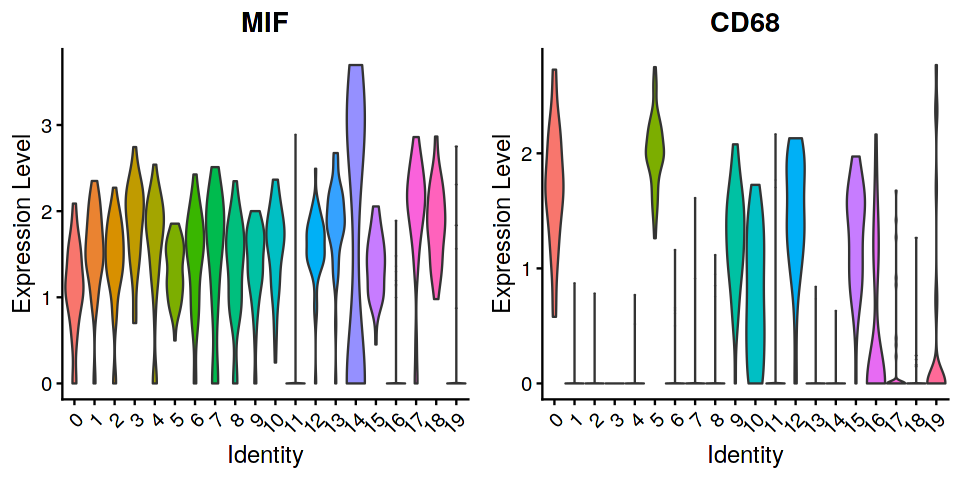

In [181]:
options(repr.plot.width=8, repr.plot.height=4)
VlnPlot(scRNA_sub, features = c("MIF", "CD68"), pt.size = 0)+NoLegend()

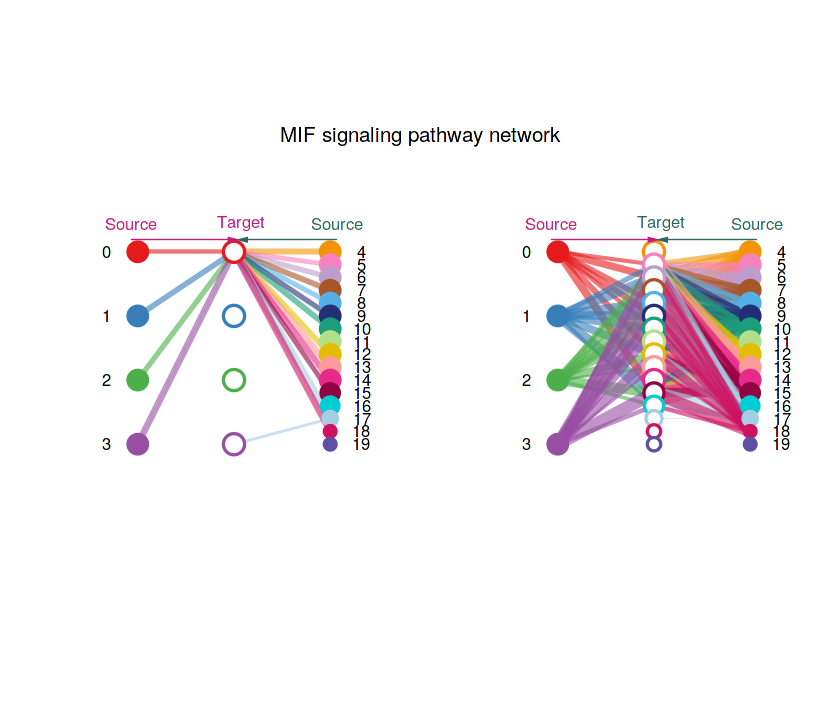

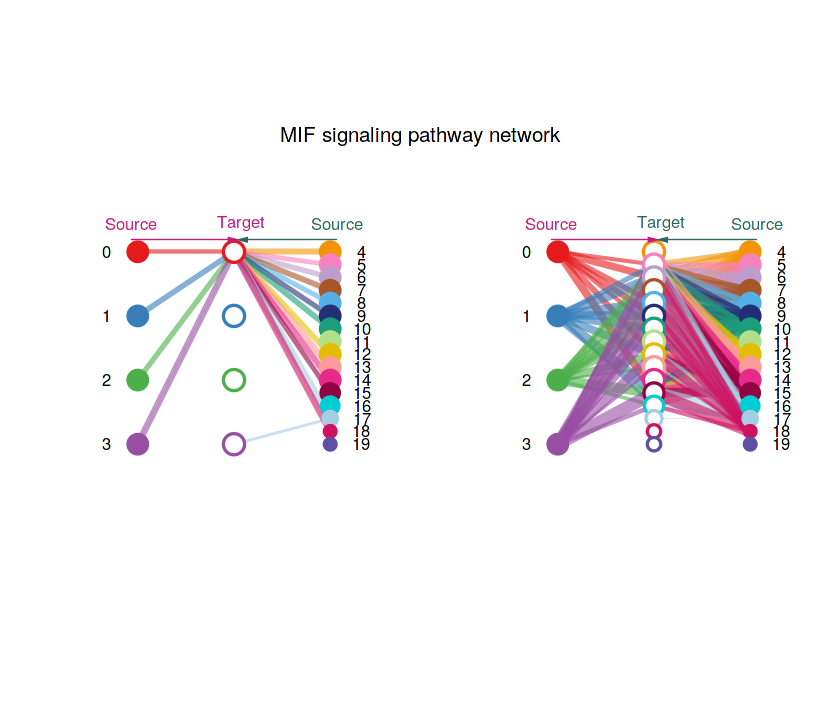

In [103]:
# 参数
pathways.show <- "MIF" #MIF Gene (Protein Coding) Macrophage Migration Inhibitory Factor
groupSize=2

options(repr.plot.width=7, repr.plot.height=6)

netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver, vertex.size = groupSize)   # 原函数

# mynetVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver, vertex.size = groupSize)  
# 原函数这里似乎有一个和igraph相关的小问题在不同igraph可能会表现bug，不巧我遇到了，de了它。

### 经典的配受体圈图

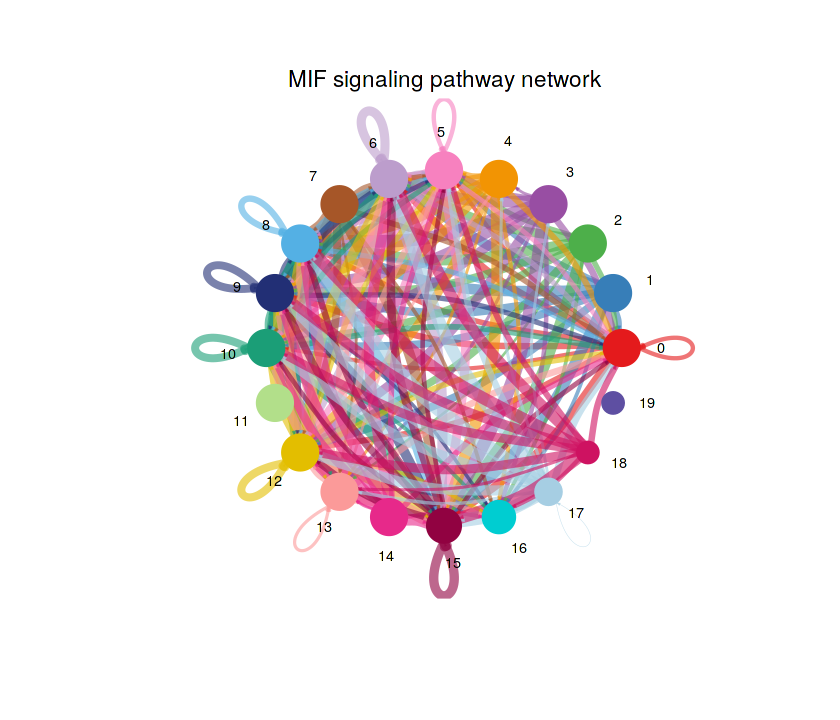

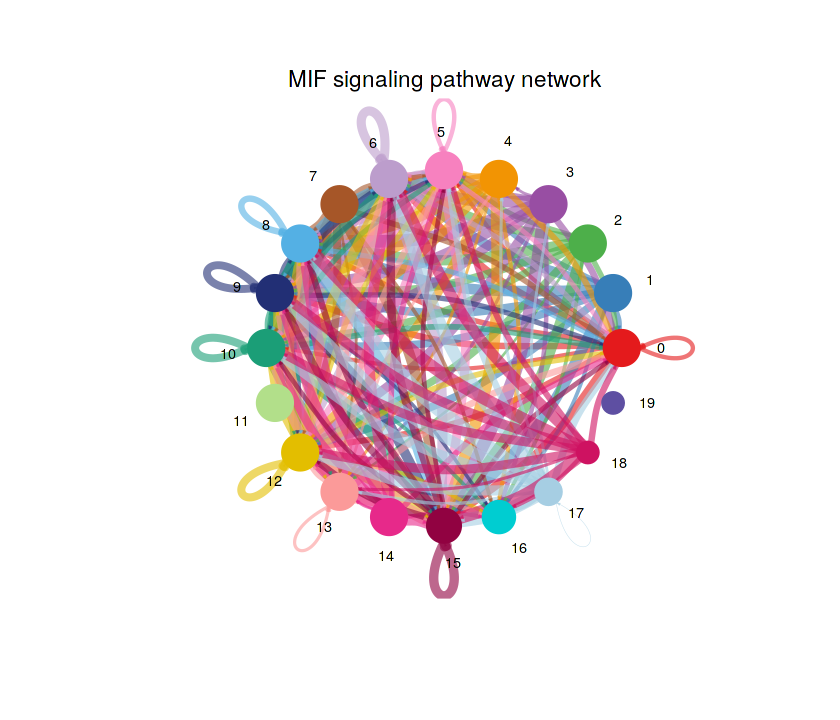

In [113]:
groupSize=1000
netVisual_aggregate(cellchat, signaling = c("MIF"), 
                    layout = "circle", 
                    vertex.size = groupSize,
                    pt.title=1,
                    vertex.label.cex = 0.7)

### 计算和可视化每个配体-受体对整个信号通路的贡献度。

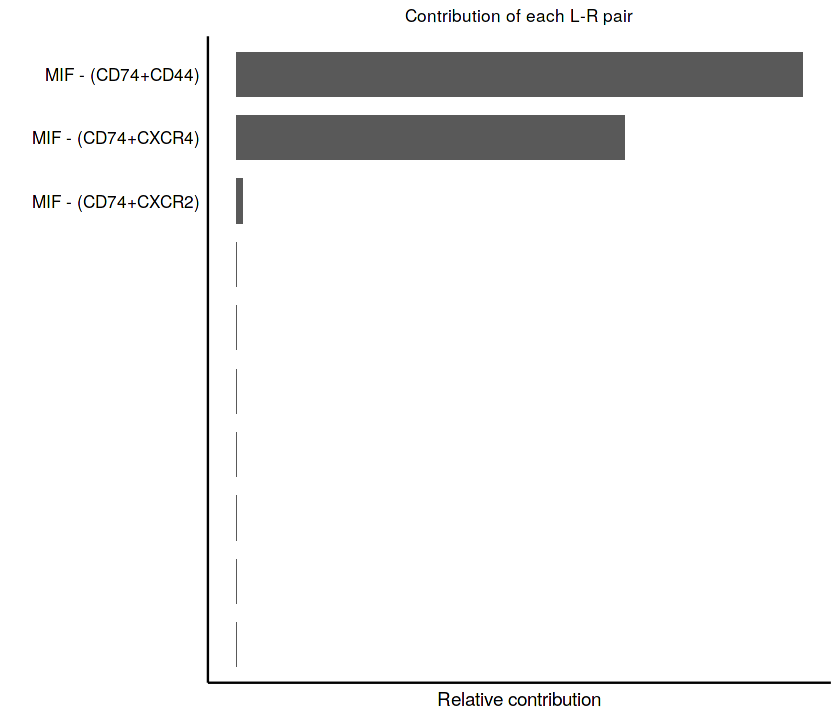

In [113]:
netAnalysis_contribution(cellchat, signaling = pathways.show)

### 发送者、接收者、调解者和影响者

识别细胞群的信号转导作用，通过计算每个细胞群的网络中心性指标，CellChat允许随时识别细胞间通信网络中的主要发送者、接收者、调解者和影响者。

这里改函数名了： https://github.com/sqjin/CellChat/issues/141

In [174]:
pathways.show

[1] "MIF"

In [163]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") 
# the slot 'netP' means the inferred intercellular communication network of signaling pathways

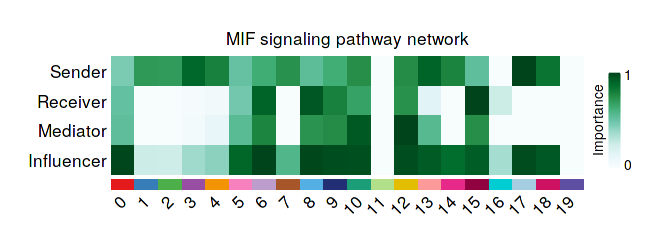

In [173]:
options(repr.plot.width=5.5, repr.plot.height=2)
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                  width = 10, height = 2.5, font.size = 10)

### outgoing: 全局探索 流出的信号

识别特定细胞群的全局通信模式和主要信号。除了探索单个通路的详细通讯外，一个重要的问题是多个细胞群和信号通路如何协调运作。CellChat采用模式识别方法来识别全局通信模式以及每个小群的关键信号。

识别分泌细胞外向交流模式。随着模式数量的增加，可能会出现冗余的模式，使得解释通信模式变得困难。我们选择了5种模式作为默认模式。一般来说，当模式的数量大于2时就可以认为具有生物学意义。

#### identifyCommunicationPatterns(heatmap)

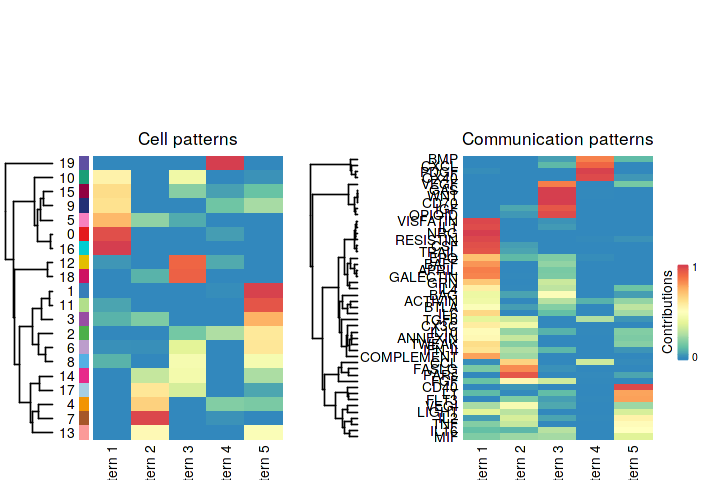

In [127]:
nPatterns = 5 

options(repr.plot.width=6, repr.plot.height=4)
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "outgoing", k = nPatterns)

#### 桑吉图

Please make sure you have load `library(ggalluvial)` when running this function



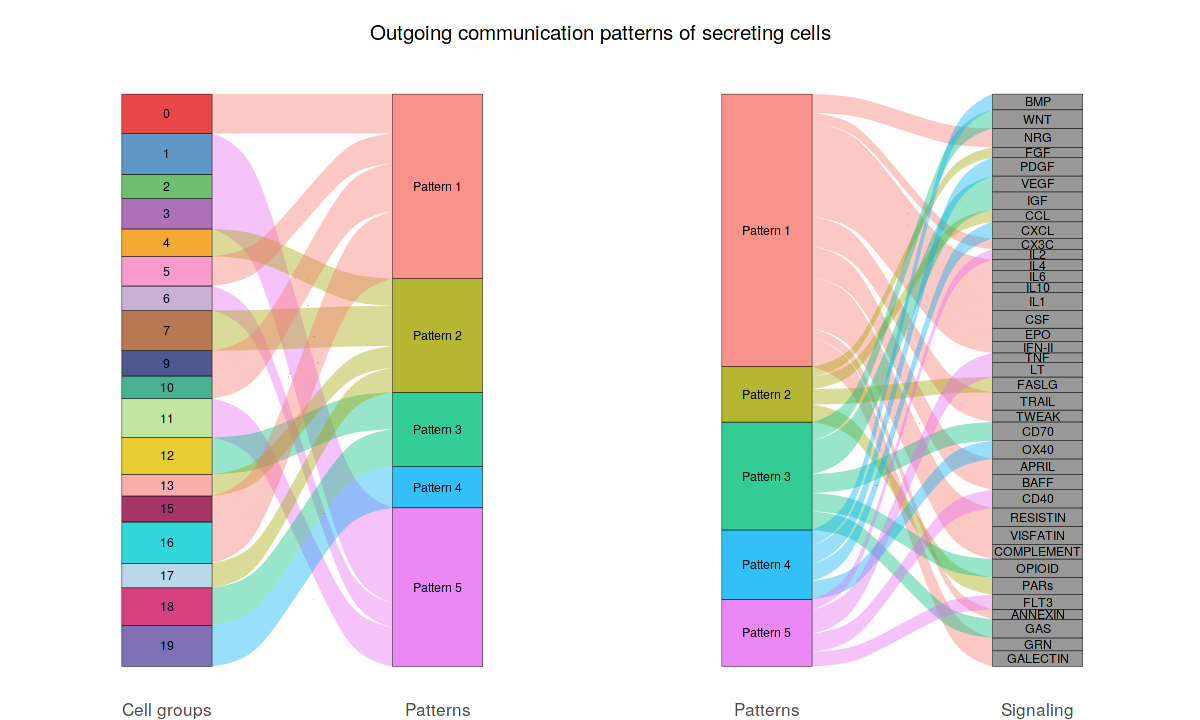

In [158]:
# Visualize the communication pattern using river plot

options(repr.plot.width=10, repr.plot.height=6)
netAnalysis_river(cellchat, pattern = "outgoing")

#### 点图

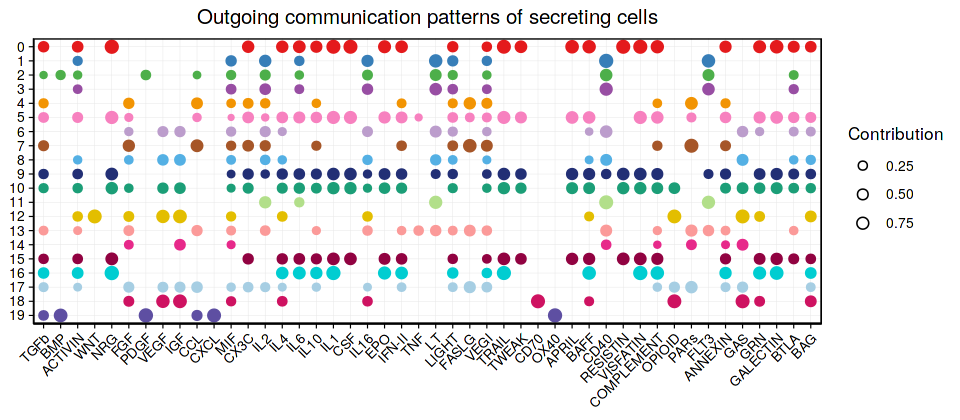

In [157]:
# Visualize the communication pattern using dot plot

options(repr.plot.width=8, repr.plot.height=3.5)
netAnalysis_dot(cellchat, pattern = "outgoing")

## 识别传入(incoming)通信模式

### identifyCommunicationPatterns

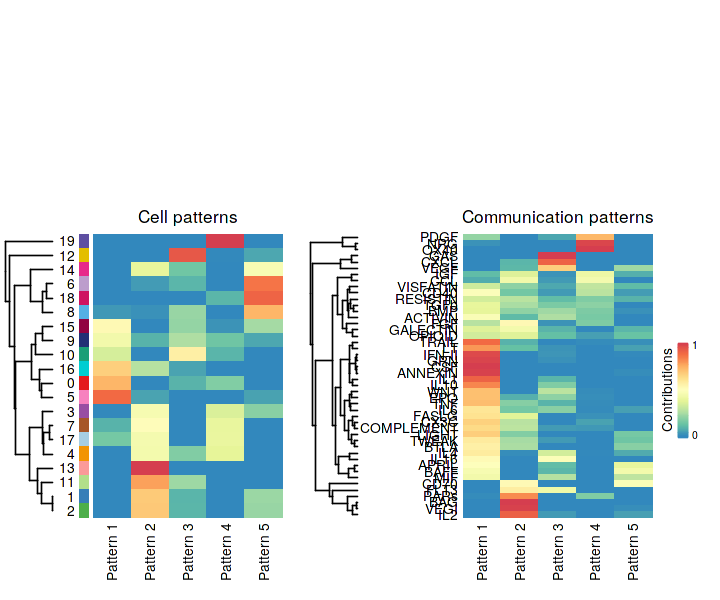

In [155]:
nPatterns = 5 

options(repr.plot.width=6, repr.plot.height=5)
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)

In [ ]:
# check
# head( methods::slot(cellchat, "netP")$pattern[['incoming']] ) #这个有数据才能接着画图

### 桑基图

Please make sure you have load `library(ggalluvial)` when running this function



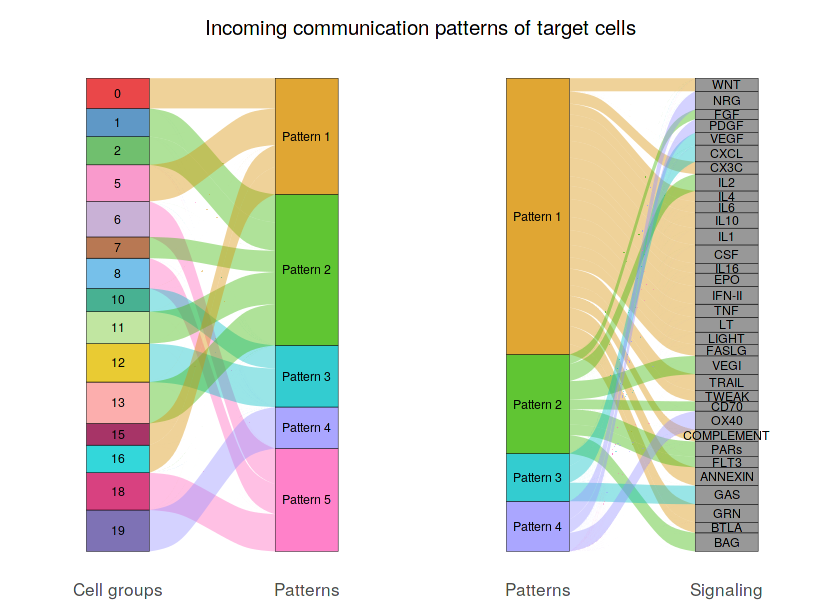

In [151]:
# 识别目标细胞的传入(incoming)通信模式

options(repr.plot.width=7, repr.plot.height=5)
netAnalysis_river(cellchat, pattern = "incoming") #pattern "outgoing" or "incoming"

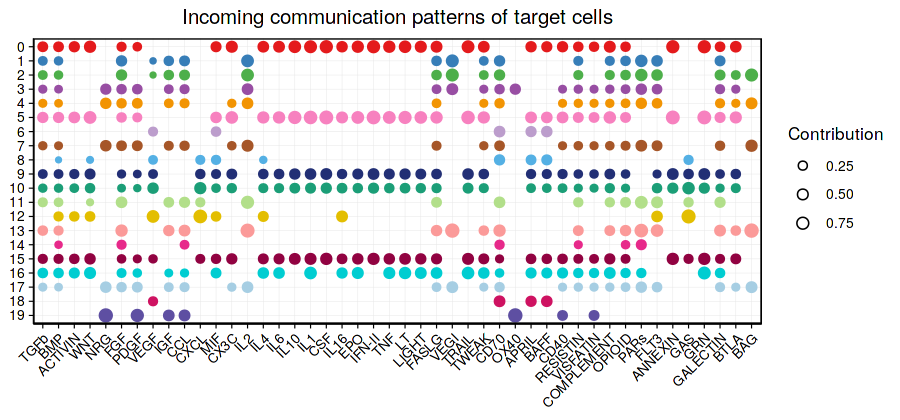

In [150]:
options(repr.plot.width=7.5, repr.plot.height=3.5)
netAnalysis_dot(cellchat, pattern = "incoming")

# CellChat 更紧凑的实例

## 准备

In [343]:
library(CellChat)
library(ggplot2)
library(ggalluvial)
library(svglite)
library(Seurat)
options(stringsAsFactors = FALSE)

In [344]:
head(scRNA@active.ident)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
      CD14+ Mono            CD8 T       CD14+ Mono               NK 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
      CD14+ Mono       CD14+ Mono 
11 Levels: CD14+ Mono Naive CD4 T CD8 T Memory CD4 T FCGR3A+ Mono B NK ... Platelet

In [345]:
## 准备数据: 取 子集，如果全用时间太长。
# 计算机强了可以都用，略过这一步。

set.seed(20210217)
scRNA_sub=subset(scRNA, idents = "?", invert=TRUE) #? has ultra low RNA
scRNA_sub=subset(scRNA_sub, downsample=50)

table(scRNA_sub@active.ident)


  CD14+ Mono  Naive CD4 T        CD8 T Memory CD4 T FCGR3A+ Mono            B 
          50           50           50           50           50           50 
          NK           DC     CD4+ CTL     Platelet 
          50           50           50           23 

In [347]:
scRNA_sub@meta.data$cellType=factor(as.character(scRNA_sub@meta.data$cellType))
table(scRNA_sub@meta.data$cellType)


           B   CD14+ Mono     CD4+ CTL        CD8 T           DC FCGR3A+ Mono 
          50           50           50           50           50           50 
Memory CD4 T  Naive CD4 T           NK     Platelet 
          50           50           50           23 

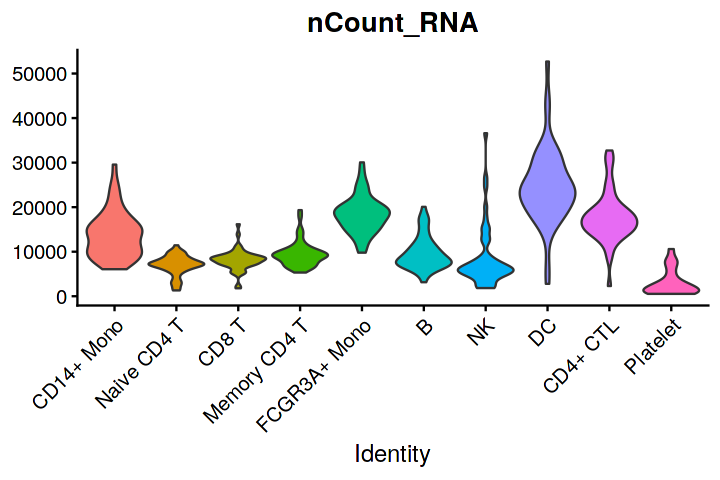

In [353]:
options(repr.plot.width=6, repr.plot.height=4)

VlnPlot(scRNA_sub, features = "nCount_RNA", pt.size = 0)+NoLegend()

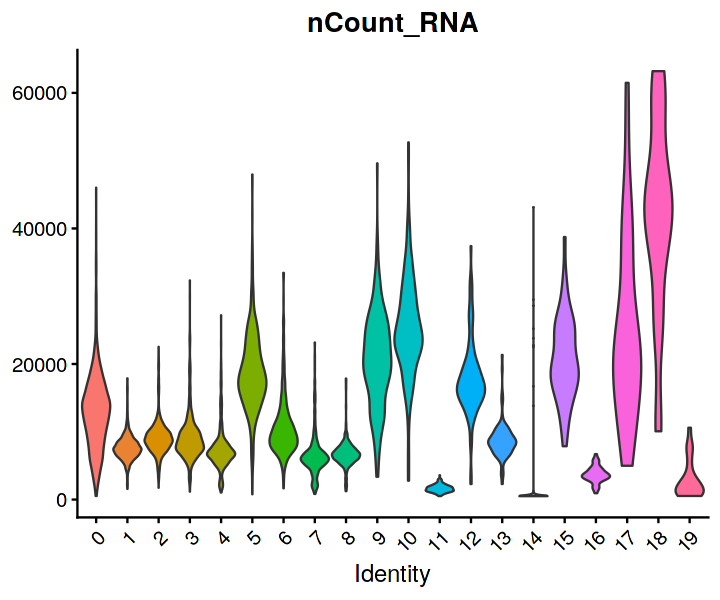

In [418]:
# all cells
VlnPlot(scRNA, features = "nCount_RNA", pt.size = 0, group.by="seurat_clusters" )+NoLegend()

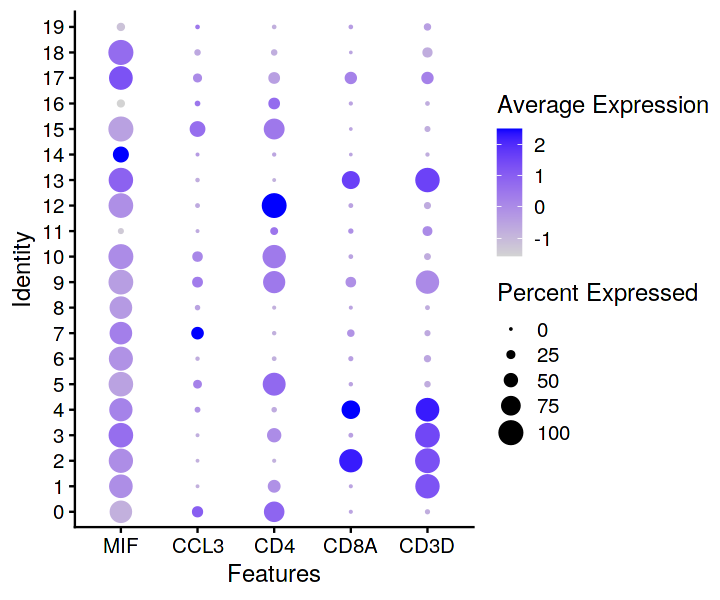

In [416]:
options(repr.plot.width=6, repr.plot.height=5)

DotPlot(scRNA, features=c("CD3D","CD8A","CD4","CCL3","MIF"), group.by="seurat_clusters" )

In [317]:
# del 1
library(Seurat)
scRNA=readRDS("/data/wangjl/scScripts/backup/a1/pbmc10k_final.rds")
scRNA

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [329]:
# del
set.seed(20210217)
scRNA0=scRNA
Idents(scRNA0)="cellType"

scRNA_sub=subset(scRNA0, ident="?", invert=T)

scRNA_sub@meta.data$cellType=factor(as.character(scRNA_sub@meta.data$cellType))
scRNA_sub=subset(scRNA_sub, downsample=50)

# check
levels(scRNA_sub@active.ident)
levels(scRNA_sub@meta.data$cellType)
table(scRNA_sub@active.ident)
scRNA_sub

[1] "B"            "CD14+ Mono"   "CD4+ CTL"     "CD8 T"        "DC"          
 [6] "FCGR3A+ Mono" "Memory CD4 T" "Naive CD4 T"  "NK"           "Platelet"

[1] "B"            "CD14+ Mono"   "CD4+ CTL"     "CD8 T"        "DC"          
 [6] "FCGR3A+ Mono" "Memory CD4 T" "Naive CD4 T"  "NK"           "Platelet"


           B   CD14+ Mono     CD4+ CTL        CD8 T           DC FCGR3A+ Mono 
          50           50           50           50           50           50 
Memory CD4 T  Naive CD4 T           NK     Platelet 
          50           50           50           23 

An object of class Seurat 
22860 features across 473 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [354]:
# 2
# creat obj
cellchat2 <- createCellChat( object = scRNA_sub@assays$RNA@data, 
                            meta=scRNA_sub@meta.data, group.by="cellType")
cellchat2

summary(cellchat2)
#str(cellchat)
table(cellchat2@idents)

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  B CD14+ Mono CD4+ CTL CD8 T DC FCGR3A+ Mono Memory CD4 T Naive CD4 T NK Platelet 


An object of class CellChat created from a single dataset 
 22860 genes.
 473 cells.

  Length    Class     Mode 
       1 CellChat       S4 


           B   CD14+ Mono     CD4+ CTL        CD8 T           DC FCGR3A+ Mono 
          50           50           50           50           50           50 
Memory CD4 T  Naive CD4 T           NK     Platelet 
          50           50           50           23 

## 加载CellChatDB数据库

In [355]:
table(CellChatDB.human$interaction$annotation)


 Cell-Cell Contact       ECM-Receptor Secreted Signaling 
               319                421               1199 

In [356]:
# 3
# add DB
## load DB
CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") # use Secreted Signaling for cell-cell communication analysis
cellchat2@DB <- CellChatDB.use # set the used database in the object

## 预处理表达数据以进行细胞间相互作用分析

In [357]:
# 4. 预处理
cellchat2 <- subsetData(cellchat2)
# ok
cellchat2 <- identifyOverExpressedGenes(cellchat2)
cellchat2 <- identifyOverExpressedInteractions(cellchat2)
cellchat2 <- projectData(cellchat2, PPI.human)  

## 推断细胞间相互作用网络与分析

In [358]:
cellchat2 <- computeCommunProb(cellchat2) # 3min;

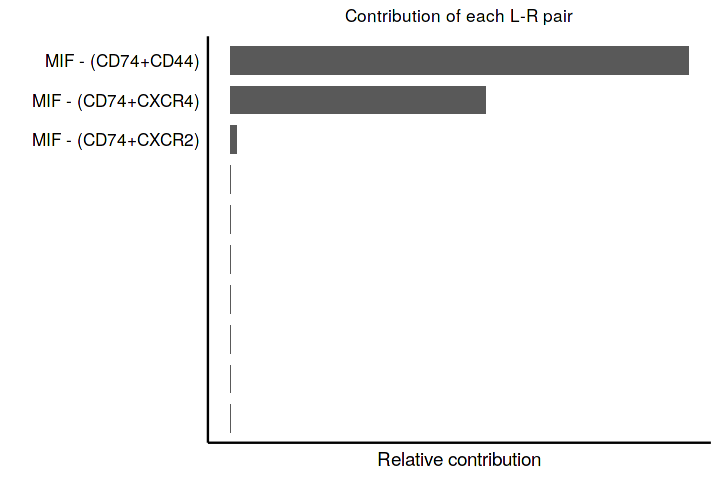

In [359]:
cellchat2 <- computeCommunProbPathway(cellchat2)
cellchat2 <- aggregateNet(cellchat2)

# pathways.show= 'MIF'
netAnalysis_contribution(cellchat2, signaling = pathways.show)
# Compute and visualize the contribution of each ligand-receptor pair to the overall signaling pathway

In [362]:
cellchat2 <- netAnalysis_computeCentrality(cellchat2, slot.name = "netP") 

cellchat2

An object of class CellChat created from a single dataset 
 22860 genes.
 473 cells.

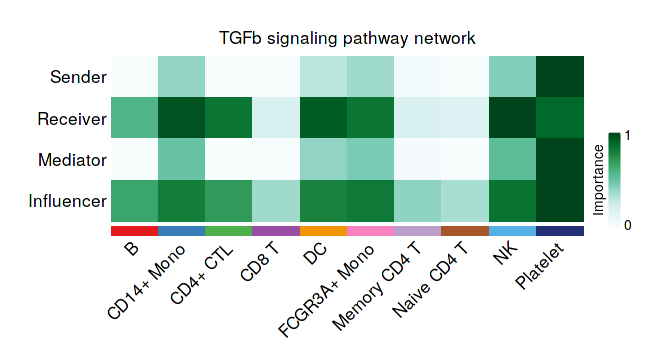

In [366]:
options(repr.plot.width=5.5, repr.plot.height=3)

pathways.show <- c("TGFb") 
#如果不指定 signaling ，则输出全部信号通路
#netAnalysis_signalingRole_network(cellchat2, slot.name = "netP")
netAnalysis_signalingRole_network(cellchat2, signaling = pathways.show, width = 10, height = 3.5, font.size = 10)

### 桑基图

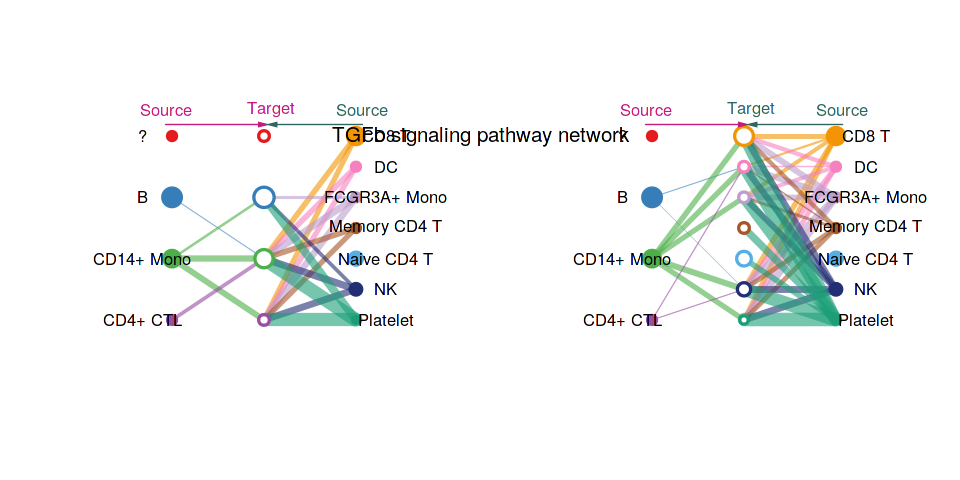

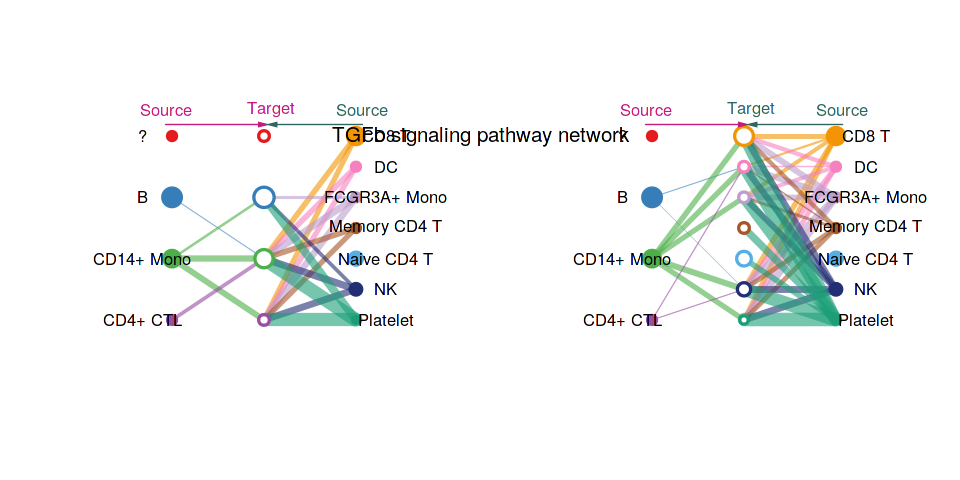

In [393]:
## 为什么乱码呢？ 底部小图正常
pathways.show <- c("TGFb") 
vertex.receiver = c(1,2,3,4) # a numeric vector

options(repr.plot.width=8, repr.plot.height=4)
netVisual_aggregate(cellchat, signaling = pathways.show,  
                    vertex.receiver = vertex.receiver, 
                    vertex.size = groupSize) # Hierarchy plot

### 环形图

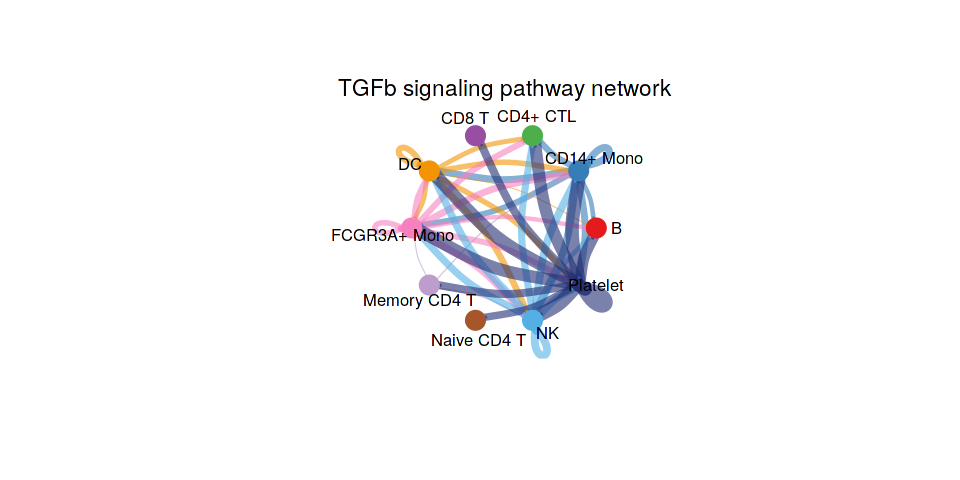

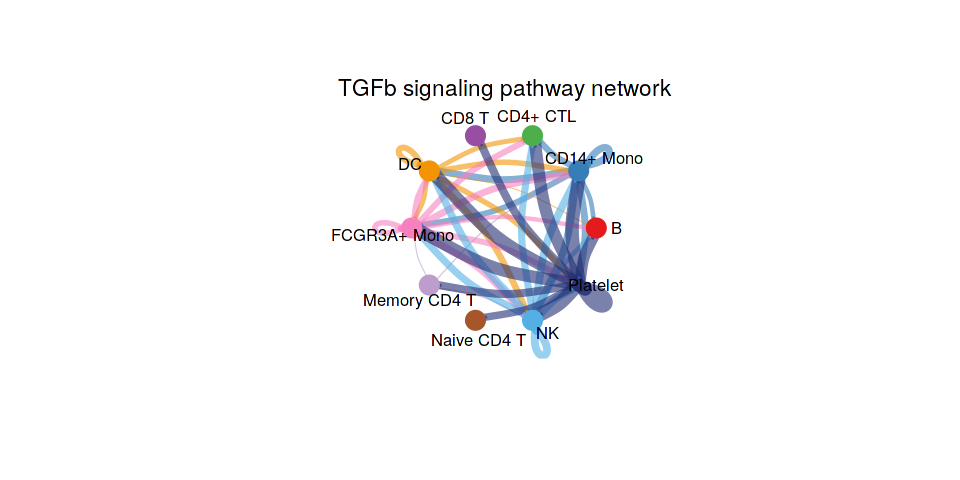

In [394]:
netVisual_aggregate(cellchat2, signaling = pathways.show, layout = "circle", vertex.size = groupSize) # Circle plot

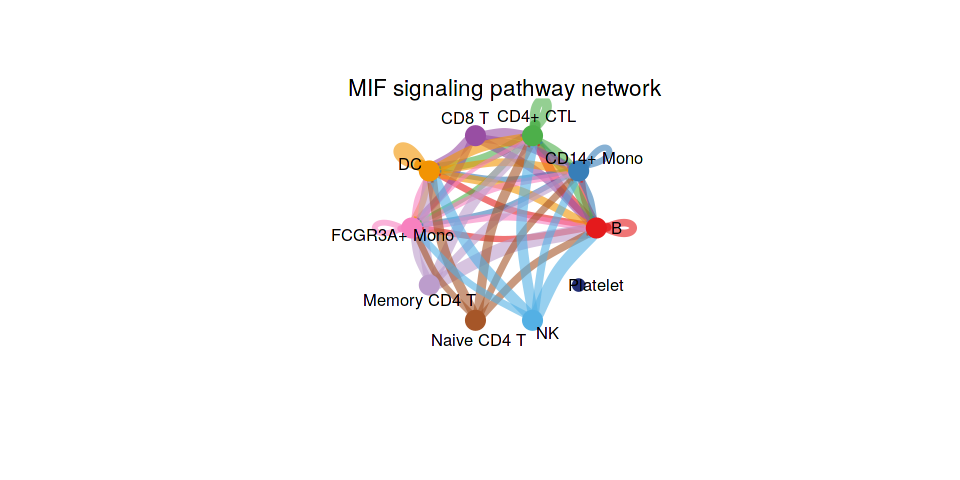

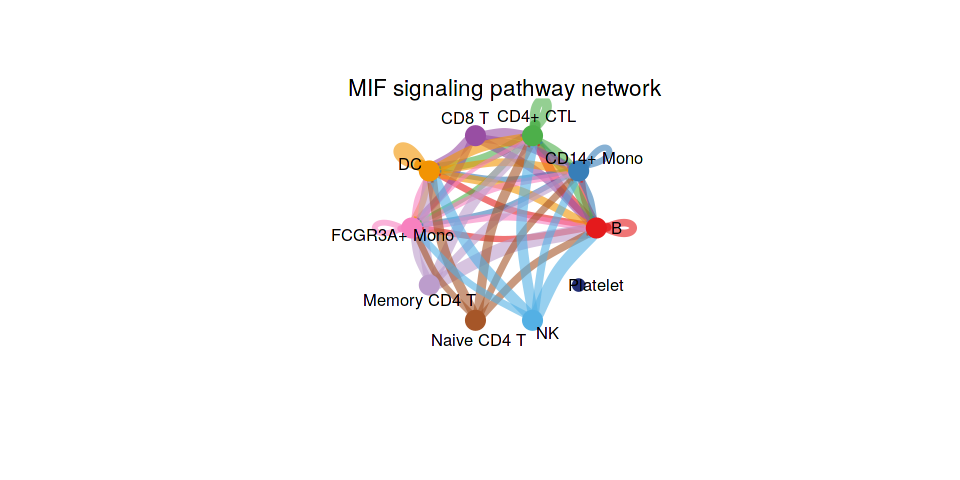

In [407]:
netVisual_aggregate(cellchat2, signaling = "MIF", layout = "circle", vertex.size = groupSize) # Circle plot

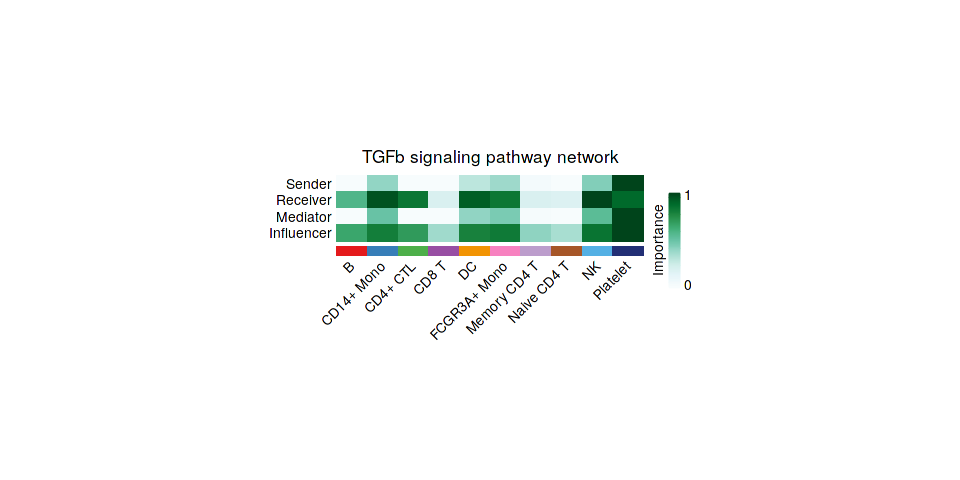

In [397]:
netAnalysis_signalingRole_network(cellchat2, signaling = pathways.show) #Visualize the signaling roles of cell groups
#could not find function "netVisual_signalingRole"

### outgoing

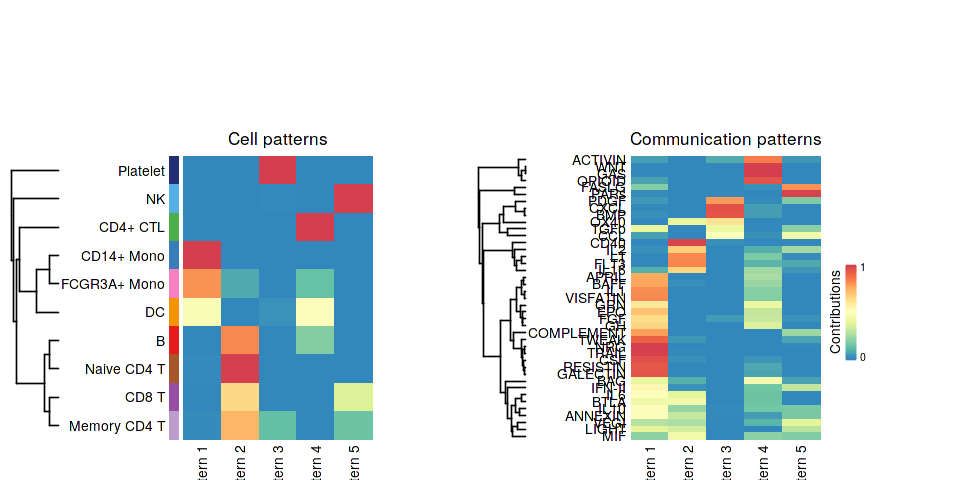

In [401]:
nPatterns = 5
cellchat2 <- identifyCommunicationPatterns(cellchat2, pattern = "outgoing", k = nPatterns)

Please make sure you have load `library(ggalluvial)` when running this function



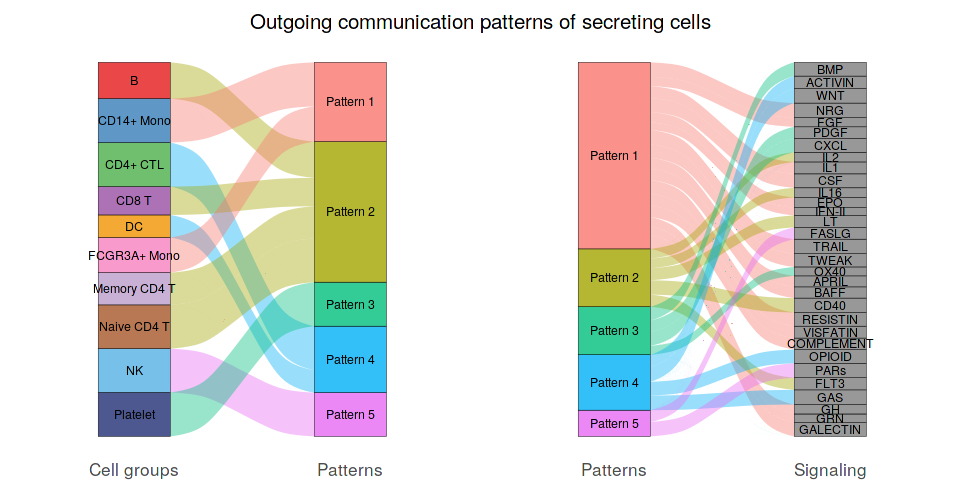

In [402]:
netAnalysis_river(cellchat2, pattern = "outgoing") # river plot

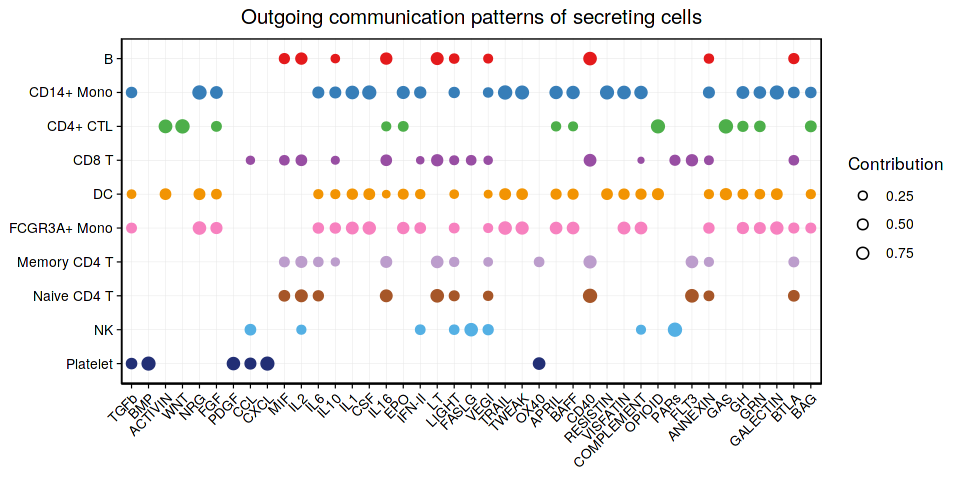

In [403]:
netAnalysis_dot(cellchat2, pattern = "outgoing") # dot plot

### incoming

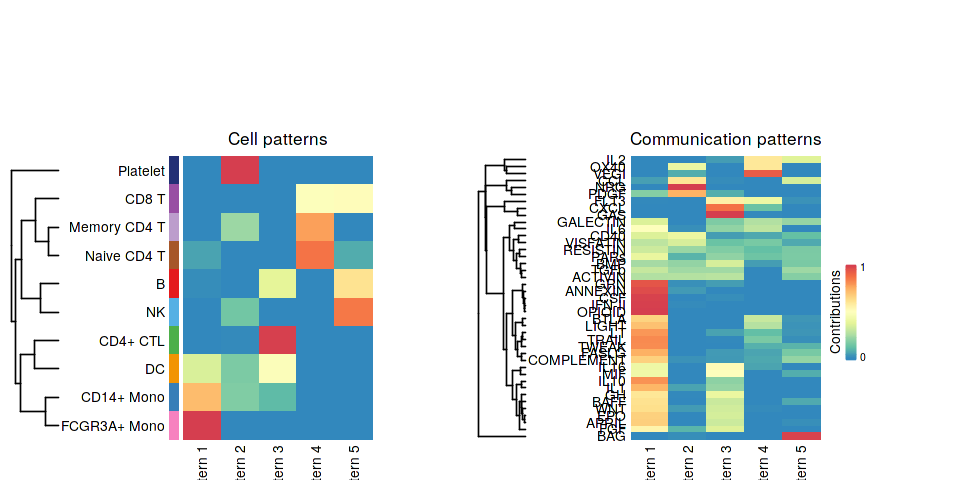

In [404]:
cellchat2 <- identifyCommunicationPatterns(cellchat2, pattern = "incoming", k = nPatterns)

Please make sure you have load `library(ggalluvial)` when running this function



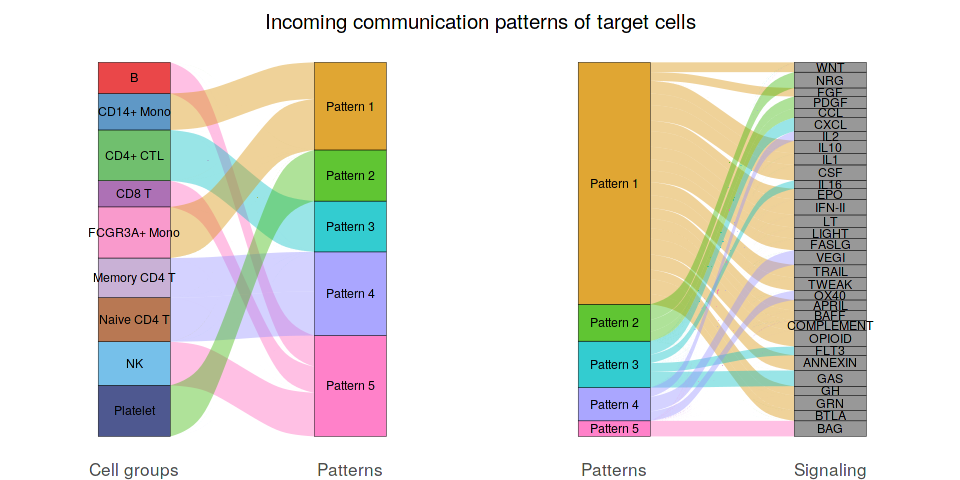

In [405]:
netAnalysis_river(cellchat2, pattern = "incoming") # river plot

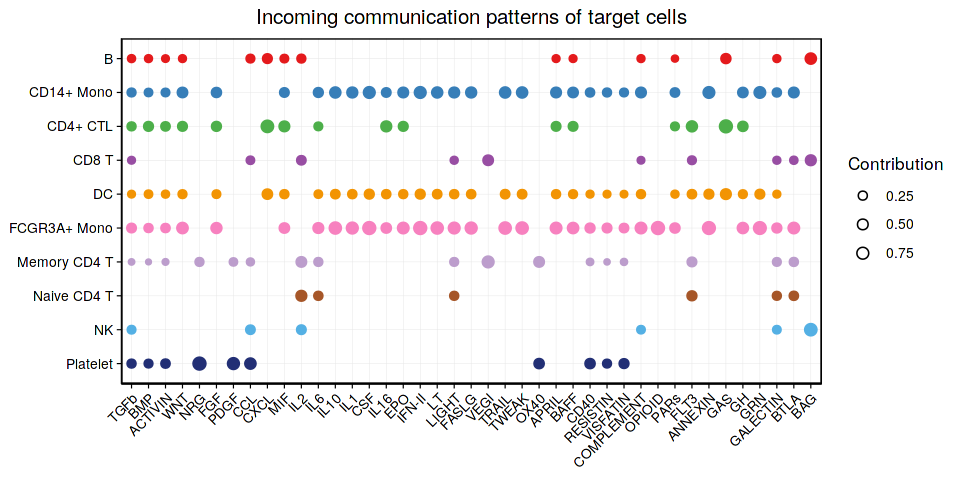

In [406]:
netAnalysis_dot(cellchat2, pattern = "incoming") # dot plot

### 在Rstudio中绘图

In [390]:
outputRoot

[1] "/data/wangjl/scScripts/backup/b2/"

In [389]:
saveRDS(cellchat2, file = paste0(outputRoot, "cellchat2.obj.rds"))
# 接下来到 Rstudio中绘图，否则总是乱码

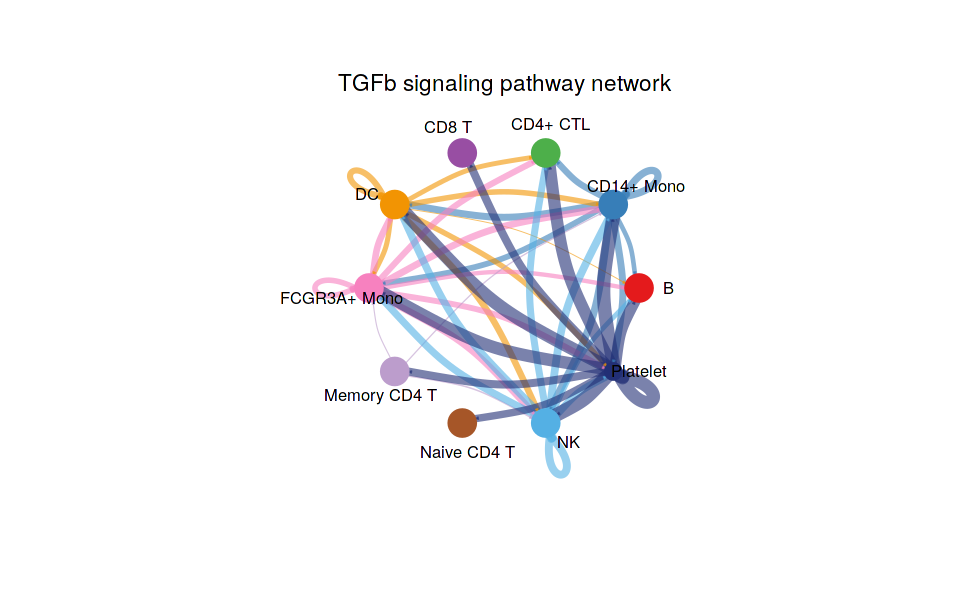

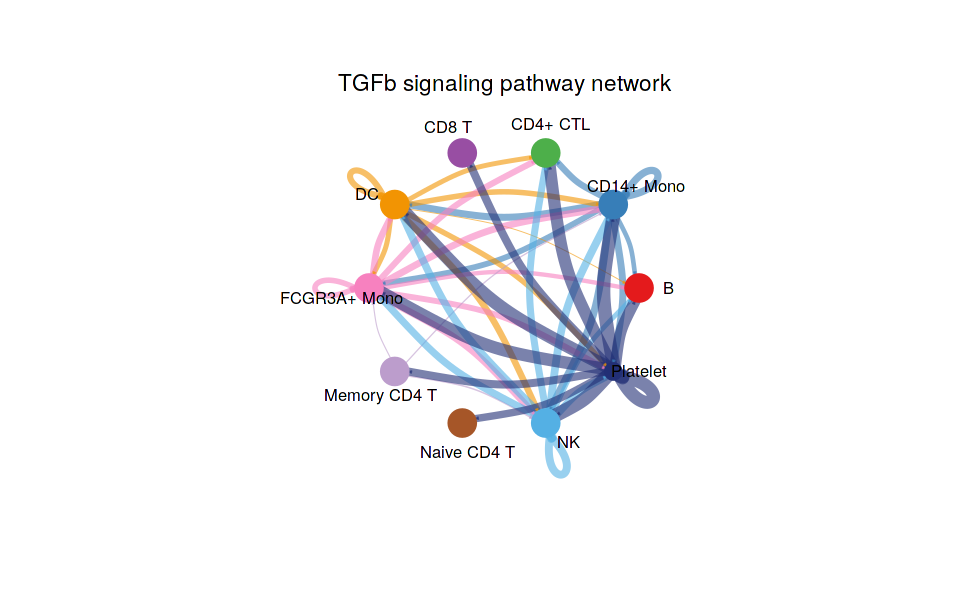

In [387]:
cellchat2=readRDS( paste0(outputRoot,"cellchat2.obj.rds") )
cellchat=cellchat2
#
pathways.show <- c("TGFb") 
vertex.receiver = seq(1,9) # a numeric vector
#
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver, vertex.size = groupSize) # Hierarchy plot
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle", vertex.size = groupSize) # Circle plot
netVisual_signalingRole(cellchat, signaling = pathways.show) #Visualize the signaling roles of cell groups
nPatterns = 5
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "outgoing", k = nPatterns)
netAnalysis_river(cellchat, pattern = "outgoing") # river plot
netAnalysis_dot(cellchat, pattern = "outgoing") # dot plot
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)
netAnalysis_river(cellchat, pattern = "incoming") # river plot
netAnalysis_dot(cellchat, pattern = "incoming") # dot plot

# #补充 CellChat 的探索数据结构

看看cellchat配受体推断的结构是如何的。

In [183]:
str(cellchat)

Formal class 'CellChat' [package "CellChat"] with 14 slots
  ..@ data.raw      : num[0 , 0 ] 
  ..@ data          :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:2559713] 33 38 61 63 133 151 154 186 207 213 ...
  .. .. ..@ p       : int [1:918] 0 1516 3951 6331 8448 10506 15356 15679 17409 19152 ...
  .. .. ..@ Dim     : int [1:2] 22860 917
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:22860] "AL627309.1" "AL627309.3" "AL627309.5" "AL627309.4" ...
  .. .. .. ..$ : chr [1:917] "AAACCCAGTTATCTTC" "AAACGAACAGAGATTA" "AAACGAATCCGCTAGG" "AAAGAACTCTGGGTCG" ...
  .. .. ..@ x       : num [1:2559713] 1.34 1.34 1.34 1.34 1.34 ...
  .. .. ..@ factors : list()
  ..@ data.signaling:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:36938] 10 18 34 38 78 94 95 105 109 154 ...
  .. .. ..@ p       : int [1:918] 0 27 67 94 127 155 215 218 239 262 ...
  .. .. ..@ Dim     : int [1:2] 499 917
  .. .. ..@ Dimnames:List of 2


In [182]:
head(cellchat@LR$LRsig)

interaction_name    pathway_name ligand receptor     
TGFB1_TGFBR1_TGFBR2 TGFB1_TGFBR1_TGFBR2 TGFb         TGFB1  TGFbR1_R2    
TGFB2_TGFBR1_TGFBR2 TGFB2_TGFBR1_TGFBR2 TGFb         TGFB2  TGFbR1_R2    
TGFB3_TGFBR1_TGFBR2 TGFB3_TGFBR1_TGFBR2 TGFb         TGFB3  TGFbR1_R2    
TGFB1_ACVR1B_TGFBR2 TGFB1_ACVR1B_TGFBR2 TGFb         TGFB1  ACVR1B_TGFbR2
TGFB1_ACVR1C_TGFBR2 TGFB1_ACVR1C_TGFBR2 TGFb         TGFB1  ACVR1C_TGFbR2
TGFB2_ACVR1B_TGFBR2 TGFB2_ACVR1B_TGFBR2 TGFb         TGFB2  ACVR1B_TGFbR2
                    agonist      antagonist      co_A_receptor
TGFB1_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB2_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB3_TGFBR1_TGFBR2 TGFb agonist TGFb antagonist              
TGFB1_ACVR1B_TGFBR2 TGFb agonist TGFb antagonist              
TGFB1_ACVR1C_TGFBR2 TGFb agonist TGFb antagonist              
TGFB2_ACVR1B_TGFBR2 TGFb agonist TGFb antagonist              
                    co_I_receptor            evidence       annotation        
TGFB1_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB2_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB3_TGFBR1_TGFBR2 TGFb inhibition receptor KEGG: hsa04350 Secreted Signaling
TGFB1_ACVR1B_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
TGFB1_ACVR1C_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
TGFB2_ACVR1B_TGFBR2 TGFb inhibition receptor PMID: 27449815 Secreted Signaling
                    interaction_name_2     
TGFB1_TGFBR1_TGFBR2 TGFB1 - (TGFBR1+TGFBR2)
TGFB2_TGFBR1_TGFBR2 TGFB2 - (TGFBR1+TGFBR2)
TGFB3_TGFBR1_TGFBR2 TGFB3 - (TGFBR1+TGFBR2)
TGFB1_ACVR1B_TGFBR2 TGFB1 - (ACVR1B+TGFBR2)
TGFB1_ACVR1C_TGFBR2 TGFB1 - (ACVR1C+TGFBR2)
TGFB2_ACVR1B_TGFBR2 TGFB2 - (ACVR1B+TGFBR2)

In [187]:
head(cellchat@data[,1:4])

6 x 4 sparse Matrix of class "dgCMatrix"
           AAACCCAGTTATCTTC AAACGAACAGAGATTA AAACGAATCCGCTAGG AAAGAACTCTGGGTCG
AL627309.1                .                .        .                        .
AL627309.3                .                .        .                        .
AL627309.5                .                .        .                        .
AL627309.4                .                .        .                        .
AL669831.2                .                .        .                        .
LINC01409                 .                .        0.7547194                .

In [188]:
head(cellchat@idents)

[1] 7  7  8  13 4  17
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [189]:
head(cellchat@meta)

group
AAACCCAGTTATCTTC 7    
AAACGAACAGAGATTA 7    
AAACGAATCCGCTAGG 8    
AAAGAACTCTGGGTCG 13   
AAAGGATTCATTCACT 4    
AAAGGTACAACTTCTT 17

In [190]:
head(cellchat@netP$pathways)

[1] "TGFb"    "BMP"     "ACTIVIN" "WNT"     "NRG"     "FGF"

In [191]:
head(cellchat@netP$prob)

[1] 0.012585950 0.004590467 0.002016912 0.008719176 0.012167835 0.012069503

### 信号通路数据结构

In [193]:
names(cellchat@netP$centr)

[1] "TGFb"       "BMP"        "ACTIVIN"    "WNT"        "NRG"       
 [6] "FGF"        "PDGF"       "VEGF"       "IGF"        "CCL"       
[11] "CXCL"       "MIF"        "CX3C"       "IL2"        "IL4"       
[16] "IL6"        "IL10"       "IL1"        "CSF"        "IL16"      
[21] "EPO"        "IFN-II"     "TNF"        "LT"         "LIGHT"     
[26] "FASLG"      "VEGI"       "TRAIL"      "TWEAK"      "CD70"      
[31] "OX40"       "APRIL"      "BAFF"       "CD40"       "RESISTIN"  
[36] "VISFATIN"   "COMPLEMENT" "OPIOID"     "PARs"       "FLT3"      
[41] "ANNEXIN"    "GAS"        "GRN"        "GALECTIN"   "BTLA"      
[46] "BAG"

In [194]:
cellchat@netP$centr$WNT

$outdeg
           0            1            2            3            4            5 
0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 
           6            7            8            9           10           11 
0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 
          12           13           14           15           16           17 
0.0001139216 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 
          18           19 
0.0000000000 0.0000000000 

$indeg
           0            1            2            3            4            5 
1.632450e-05 7.164396e-07 6.599962e-07 1.015591e-06 1.017611e-06 1.542483e-05 
           6            7            8            9           10           11 
6.926544e-07 9.692423e-07 6.738419e-07 1.586039e-05 2.835298e-05 5.043552e-07 
          12           13           14           15           16           17 
1.017571e-05 9.864282e-07 4.242261e-07 1.676873e-05 1.007724e-06 1.177369e-06 
          18           19 
6.677541e-07 5.012702e-07 

$hub
           0            1            2            3            4            5 
1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 
           6            7            8            9           10           11 
1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 1.263853e-17 
          12           13           14           15           16           17 
1.000000e+00 1.263853e-17 1.263853e-17 1.263853e-17 1.387779e-17 1.387779e-17 
          18           19 
1.387779e-17 1.387779e-17 

$authority
         0          1          2          3          4          5          6 
0.57575948 0.02526858 0.02327784 0.03581956 0.03589077 0.54402833 0.02442968 
         7          8          9         10         11         12         13 
0.03418484 0.02376617 0.55939052 1.00000000 0.01778843 0.35889373 0.03479098 
        14         15         16         17         18         19 
0.01496231 0.59142723 0.03554206 0.04152541 0.02355146 0.01767963 

$eigen
          0           1           2           3           4           5 
0.300194982 0.013174774 0.012136822 0.018675946 0.018713075 0.283650693 
          6           7           8           9          10          11 
0.012737381 0.017823620 0.012391435 0.291660378 0.521389562 0.009274704 
         12          13          14          15          16          17 
1.000000000 0.018139656 0.007801192 0.308363983 0.018531261 0.021650916 
         18          19 
0.012279484 0.009217973 

$page_rank
         0          1          2          3          4          5          6 
0.05410218 0.04807804 0.04805625 0.04819350 0.04819428 0.05375494 0.04806886 
         7          8          9         10         11         12         13 
0.04817561 0.04806160 0.05392306 0.05874474 0.04799618 0.05172897 0.04818224 
        14         15         16         17         18         19 
0.04796525 0.05427364 0.04819046 0.04825594 0.04805925 0.04799499 

$betweenness
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

$flowbet
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

$info
 [1] 0.12499846 0.04277180 0.04053350 0.05311591 0.05317813 0.12432255
 [7] 0.04184107 0.05166209 0.04109211 0.12465842 0.13015130 0.03379032
[13] 0.13788432 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[19] 0.00000000 0.00000000

### 每个pattern有outgoing和ingoing两种

In [199]:
names(cellchat@netP$pattern$outgoing)

[1] "data"    "pattern"

In [203]:
cellchat@netP$pattern$outgoing$data[1:4,1:9]

TGFb       BMP       ACTIVIN    WNT NRG         FGF        PDGF       
0 0.43504714 0.0000000 0.41884287 0   1.000000000 0.06843794 0.018157347
1 0.02297922 0.1407819 0.01700427 0   0.001337742 0.01468201 0.001551963
2 0.03278355 0.1318856 1.00000000 0   0.001286529 0.01173518 0.001404795
3 0.21911971 0.0000000 0.09602089 0   0.002010761 0.02102953 0.002842994
  VEGF         IGF         
0 0.0005678673 0.0446660001
1 0.1089130005 0.0002826289
2 0.0256487489 0.0041341414
3 0.0729795197 0.0042007635

In [198]:
names(cellchat@netP$pattern$outgoing$pattern)

[1] "cell"      "signaling"

In [195]:
 head(cellchat@netP$pattern$outgoing$pattern$cell)

CellGroup Pattern   Contribution
1 0         Pattern 1 9.542515e-01
2 1         Pattern 1 6.027821e-10
3 2         Pattern 1 3.894478e-10
4 3         Pattern 1 9.454798e-02
5 4         Pattern 1 1.711809e-10
6 5         Pattern 1 7.207848e-01

In [197]:
head(cellchat@netP$pattern$outgoing$pattern$signaling)

Pattern   Signaling Contribution
1 Pattern 1 TGFb      3.837059e-01
2 Pattern 2 TGFb      3.204688e-01
3 Pattern 3 TGFb      9.994910e-07
4 Pattern 4 TGFb      2.653456e-01
5 Pattern 5 TGFb      3.047867e-02
6 Pattern 1 BMP       3.119459e-08

In [196]:
 head(cellchat@netP$pattern$incoming$pattern$cell)

CellGroup Pattern   Contribution
1 0         Pattern 1 7.291808e-01
2 1         Pattern 1 4.555784e-10
3 2         Pattern 1 4.277265e-10
4 3         Pattern 1 3.095161e-03
5 4         Pattern 1 3.247161e-06
6 5         Pattern 1 8.828832e-01

### slot: net

In [204]:
names(cellchat@net)

[1] "prob"   "pval"   "count"  "weight"

In [205]:
dim(cellchat@net$prob)

[1]  20  20 434